# Load Yolo labeled data and transform into LabelMe format

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

path = "/Users/magnuswiik/prosjektoppgave_data/transfer_303045_files_86bfcc05/salmon_annotation_data_SINTEF/yolo_data_onlyfish/"

In [19]:
imgFilename = path + "SINTEF_train_OpenTransport_GP020100_part_rotated_00h00m00s_00h05m00s_000111.png"
print("Reading reference image:", imgFilename)
im1 = cv2.imread(imgFilename, cv2.IMREAD_COLOR)

im1_rgb = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)


Reading reference image: /Users/magnuswiik/prosjektoppgave_data/transfer_303045_files_86bfcc05/salmon_annotation_data_SINTEF/yolo_data_onlyfish/SINTEF_train_OpenTransport_GP020100_part_rotated_00h00m00s_00h05m00s_000111.png


In [28]:
txts = sorted(file for file in os.listdir(path) if file.endswith('.txt'))

for txt in txts:
    txtfile = path + txt
    with open(txtfile, 'r') as file:
        lines = file.readlines()

    # Filter the lines you want to keep
    keep_lines = [line for line in lines if line.startswith('2')]

    # Open the file in write mode ('w') to clear its content and write the filtered lines
    with open(txtfile, 'w') as file:
        file.writelines(keep_lines)

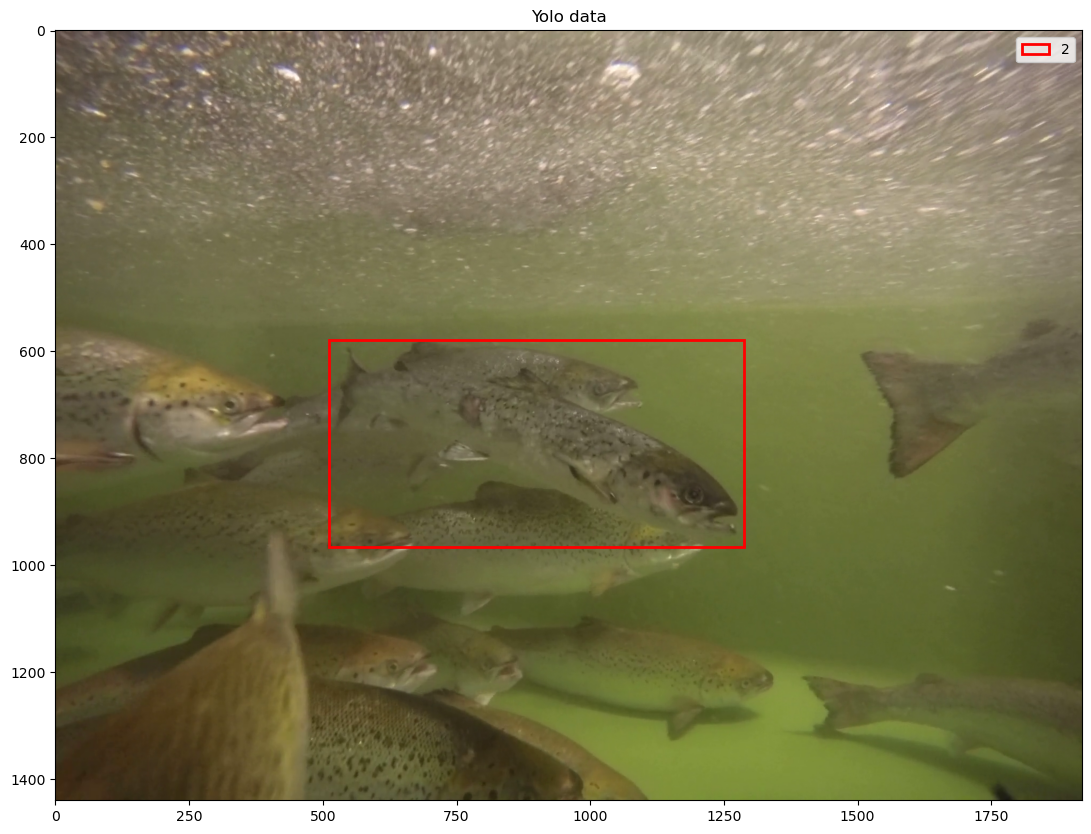

In [21]:
plt.figure(figsize=[20, 10])

plt.imshow(im1_rgb)
plt.title("Yolo data")

file = path + 'SINTEF_train_OpenTransport_GP020100_part_rotated_00h00m00s_00h05m00s_000111.txt'

with open(file, 'r') as f:
    lines = f.readlines()

for line in lines:
    # Parse the bounding box information from YOLO format (label, x_center, y_center, width, height)
    label, x_center, y_center, width, height = map(float, line.split())
    
    # Convert YOLO format to absolute coordinates
    abs_width = int(width * im1.shape[1])
    abs_height = int(height * im1.shape[0])
    abs_x = int((x_center * im1.shape[1]) - (abs_width / 2))
    abs_y = int((y_center * im1.shape[0]) - (abs_height / 2))

    # Create a Rectangle patch
    rect = patches.Rectangle((abs_x, abs_y), abs_width, abs_height, linewidth=2, edgecolor='r', facecolor='none', label=str(int(label)))
    
    # Add the Rectangle patch to the Axes
    plt.gca().add_patch(rect)

plt.legend()
plt.show()

In [22]:
# Create LabelMe dictionary

labelme_dict = {'version':'5.3.1',
                'flags':{},
                'shapes':[],
                'imagePath':'',
                'imageData': None,
                'imageHeight':1024,
                'imageWidth':1280
                }
image_sizes = {'out1':[1280,1024], 'out2':[1280,1024], 'BIORACER': [2704,1520], 'Hero4': [2704,1520], 'OpenTransport':[1920,1440]}

# Convert yolo textfiles to Labelme jsonfiles

In [27]:
import json

txts = sorted(file for file in os.listdir(path) if file.endswith('.txt'))

for txt in txts:
    txtfile = path + txt
    with open(txtfile, 'r') as file:
        lines = file.readlines()
    
    output = labelme_dict.copy()
    output['imagePath'] = txt[:-3] + 'png'
    
    if ('Hero4' or 'BIORACER') in txt:
        output['imageWidth'] = image_sizes['Hero4'][0]
        output['imageHeight'] = image_sizes['Hero4'][1]
    elif ('out1' or 'out2') in txt:
        output['imageWidth'] = image_sizes['out1'][0]
        output['imageHeight'] = image_sizes['out1'][1]
    elif 'OpenTransport' in txt:
        output['imageWidth'] = image_sizes['OpenTransport'][0]
        output['imageHeight'] = image_sizes['OpenTransport'][1]
    else:
        continue
    
    shapes_list = []

    for line in lines:
        
        shape_dict = {"label": "WholeSalmon", "points": [], 'group_id': None, 'description': '', 'shape_type': 'rectangle', 'flags': {}}
        
        label, x_center, y_center, width, height = map(float, line.split())
        
        # Transform to LabelMe bbox format
        abs_width = width * output['imageWidth']
        abs_height = height * output['imageHeight']
        abs_x_center = x_center * output['imageWidth']
        abs_y_center = y_center * output['imageHeight']
        
        abs_x1 = abs_x_center - abs_width / 2
        abs_y1 = abs_y_center - abs_height / 2
        abs_x2 = abs_x_center + abs_width / 2
        abs_y2 = abs_y_center + abs_height / 2
        
        shape_dict['points'] = [[abs_x1, abs_y1], [abs_x2, abs_y2]]
        
        shapes_list.append(shape_dict)
    
    output['shapes'] = shapes_list
    
    jsonfile = txtfile[:-4] + '.json'
    # Open the file in write mode ('w') to clear its content and write the filtered lines
    with open(jsonfile, 'w') as jsonfile:
        json.dump(output, jsonfile, indent=2)

# Remove images with no annotations

In [36]:
import json, os

Path_annots = '/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Christian_Annotert_Deteksjonssett/Boxes/'
Path_images = '/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Christian_Annotert_Deteksjonssett/Images/'

annotfiles = list(sorted(os.listdir(Path_annots)))

for annotfile in annotfiles:
    with open(Path_annots + annotfile, 'r') as file:
        content = json.load(file)
        if len(content['shapes']) == 0:
            file.close()
            imagefile = annotfile[:-4] + 'png'
            os.remove(Path_annots + annotfile)
            os.remove(Path_images + imagefile)

# Fix imagePath in json files

In [21]:
import os, json

path = "/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Christian_Annotert_Deteksjonssett/Boxes/"

annotfiles = list(sorted(os.listdir(path)))

for annotfile in annotfiles:
    if 'DS' not in annotfile:
        with open(path + annotfile, 'r+') as file:
            content = file.read()
            right_content = content[:content.index('}{') + 1]
            file.seek(0)  # Move the file pointer to the beginning
            file.truncate()  # Truncate the file to remove existing content
            right_content_json = json.loads(right_content)
            right_content_json["imagePath"] = annotfile[:-4] + 'png'
            json.dump(right_content_json, file, indent=2)